`fitting_noisey_spikey_data_01.ipynb`

> data: `generating_data/data/wu_10000_normal-uniform-noise_5-percent-normal-pi-spike.bz2`

> Attempt to correctly compute tau for each entry

##### imports and notebook setup

In [1]:
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, sys

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

from plot_styles import set_plotstyles
set_plotstyles()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### load data

In [2]:
# glob.glob("../generating_data/data/*")
data = pd.read_csv('../generating_data/data/wu_10000_normal-uniform-noise_5-percent-normal-pi-spike.bz2', compression = 'bz2')

#### split data

In [3]:
# split randomly 80% / 10%
training_data_df = data.sample(frac = 0.8)
testing_data_df = data.loc[~data.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
y_testing = testing_data_df[['tau']].values

#### scale data

In [4]:
# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
y_scaled_training = y_scaler.fit_transform(y_training)

X_scaled_testing = X_scaler.transform(X_testing)
y_scaled_testing = y_scaler.transform(y_testing)

#### declare hyper-parameters

In [6]:
number_of_inputs =  X_scaled_training.shape[1]
number_of_outputs = y_scaled_training.shape[1]

layer_1_nodes = 256
layer_2_nodes = 512
layer_3_nodes = 768
layer_4_nodes = 512
layer_5_nodes = 256

starting_epoch = 0
training_epochs = 1000

learning_rate = 0.0001

#### setup log path

In [32]:
# one random serial number per NN graph
# - add letters to end for repeated runs
# - only run this cell once!
log_random_serial_number = '{}'.format(np.random.randint(10000,99999))
log_random_serial_number

'58412'

In [11]:
def log_dir(log_random_serial_number):
    master_log_path = '../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc

#### setup NN

In [7]:
tf.reset_default_graph()

with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)
    
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1", shape = [layer_1_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights1", shape  = [number_of_inputs, layer_1_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2", shape = [layer_2_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights2", shape  = [layer_1_nodes, layer_2_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3", shape = [layer_3_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights3", shape  = [layer_2_nodes, layer_3_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

with tf.variable_scope('dropout_3_to_4'):
    drop_out = tf.nn.dropout(layer_3_output, keep_prob) 
    
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4", shape = [layer_4_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights4", shape  = [layer_3_nodes, layer_4_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_4_output = tf.nn.relu(tf.matmul(drop_out, weights) + biases)

with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5", shape = [layer_5_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights5", shape  = [layer_4_nodes, layer_5_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_5_output = tf.nn.relu(tf.matmul(layer_4_output, weights) + biases)
    
with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out", shape = [number_of_outputs], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights_out", shape  = [layer_5_nodes, number_of_outputs], initializer = tf.contrib.layers.xavier_initializer())
    prediction = tf.nn.relu(tf.matmul(layer_5_output, weights) + biases)

with tf.variable_scope('cost'):

    y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, y))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    tf.summary.histogram('predictions', prediction)
    summary = tf.summary.merge_all()

In [12]:
saver = tf.train.Saver()
log_direc = log_dir(str(58412))
print(log_direc)

../logs/58412A


In [13]:

with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/model' + '/trained_model.ckpt'

    
    for epoch  in range(training_epochs):

        # Feed in the training data and do one step NN training
        session.run(optimizer,feed_dict = {X: X_scaled_training, y: y_scaled_training, keep_prob: 0.5})

        training_feed = {X: X_scaled_training, y: y_scaled_training, keep_prob: 0.5}
        training_cost, training_summary = session.run([cost, summary], feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, y: y_scaled_testing, keep_prob: 0.5}
        testing_cost, testing_summary = session.run([cost, summary],feed_dict = testing_feed)
        
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.20f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0:
                saver.save(session, model_save_location, epoch)
            
    saver.save(session, model_save_location, epoch)

 epoch:  999 testing_cost: 0.00520521635189652443

In [19]:
with tf.Session() as session:
    saver.restore(session,model_save_location + '-999')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob: 1})
    
    # the predictions but in the original units
    prediction_unscaled = y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from ../logs/58412A/model/trained_model.ckpt-999


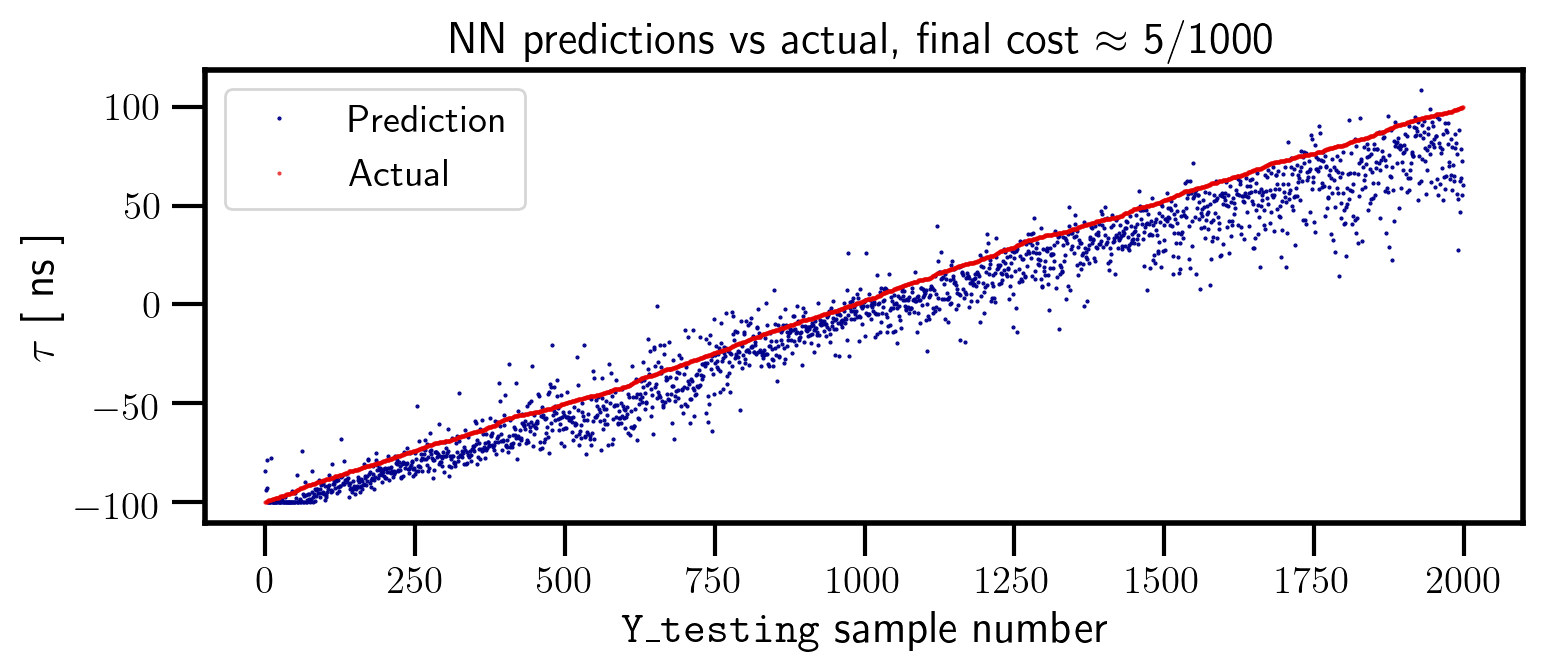

In [20]:
sorting_idx = np.argsort(y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 5/1000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')a

ax.plot(y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [22]:
NN_SCORE = sum((y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

11.315034677859556

In [24]:
np.std(abs(y_testing.T[0] - prediction_unscaled.T[0]))

9.715525650938098